In [1]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.optim import Adam

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the wine dataset
X, y = load_wine(return_X_y=True)

# Normalize the data in X to be between 0 and 1
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Add a column of ones for the intercept term
X_ones = np.c_[np.ones(X.shape[0]), X_normalized]

X_train, X_test, y_train, y_test = train_test_split(X_ones, y, test_size=0.3, random_state=42)

In [3]:
# Fit the model
model = FlatPriorLinearRegression()
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

/home/pgarcia/AdvReg/src/models/conjugate_bayes_lin_reg.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu_ast = torch.tensor(v_ast @ X.T @ y, dtype=torch.float32)


In [4]:
x_adv = X_test[17,:].copy()

In [5]:
# Deterministic attack 
y_star = 3
epsilon = .3

mu = model.mu.numpy()

beta_dot_x = np.dot(mu, x_adv)
beta_norm_squared = np.dot(mu, mu)
x_adv_attacked = x_adv + ((y_star - beta_dot_x) / beta_norm_squared) * mu

if np.linalg.norm(np.dot(y_star - beta_dot_x, mu)) > epsilon * beta_norm_squared: 
    beta_norm_squared = np.linalg.norm(mu)**2
    sign_term = np.sign(y_star - beta_dot_x)
    delta_x_adv = epsilon * (np.dot(y_star - beta_dot_x, mu) / (np.linalg.norm(y_star - beta_dot_x) * np.linalg.norm(mu)))
    x_adv_attacked = x_adv + delta_x_adv

y_attacked = np.dot(mu, x_adv_attacked)

In [19]:
y_attacked

1.988047136029391

In [95]:
def reparametrization_trick(x_adv, model, G, samples_per_iteration):
    y_samples = model.sample_predictive_distribution(x_adv.unsqueeze(0), samples_per_iteration)
    gradients = 2 * (y_samples.mean() - G) * model.mu
    return gradients, y_samples.mean()

In [89]:
# reparametrization attack
def attack(x_adv, model, G, samples_per_iteration=10000, learning_rate=1e-1, num_iterations=1000, epsilon=.1):
    x_0 = x_adv.clone().detach()
    x_adv_values = []
    loss_values = []
    func_values = []

    optimizer = Adam([x_adv], lr=learning_rate)

    for _ in range(num_iterations):
        # Adam optimizer
        gradients, y_mean = reparametrization_trick(x_adv, model, G, samples_per_iteration)
        optimizer.zero_grad()

        x_adv.grad = torch.tensor(gradients, dtype=torch.float32)
        optimizer.step()
        
        with torch.no_grad():
            if torch.norm(x_adv - x_0, p=2) > epsilon:
                x_adv = x_0 + epsilon * (x_adv - x_0) / torch.norm(x_adv - x_0, p=2)
            
        x_adv_values.append(x_adv.detach())
        loss_values.append((y_mean - G) ** 2)
        func_values.append(y_mean)

    return x_adv_values, loss_values, func_values

In [90]:
y_star = 3
epsilon = .3
x_adv = X_test[17,:].copy()
x_adv = torch.tensor(x_adv, dtype=torch.float32, requires_grad=True)

x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon)

/tmp/ipykernel_3841206/2780347925.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_adv.grad = torch.tensor(gradients, dtype=torch.float32)


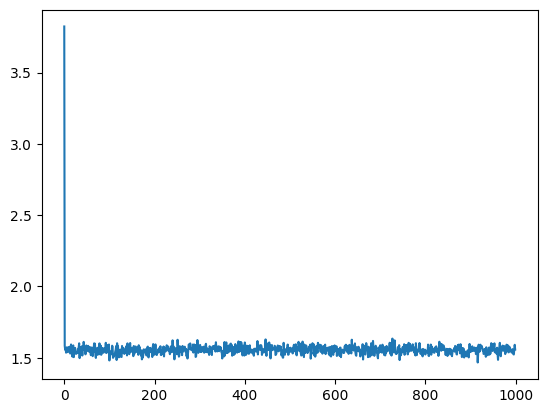

In [91]:
plt.plot(loss_values)

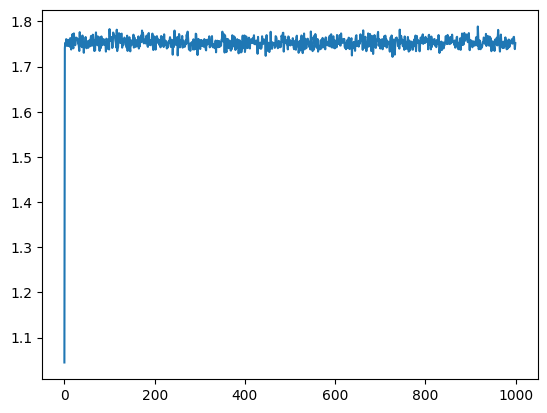

In [92]:
plt.plot(func_values)

In [93]:
torch.tensor(func_values).max()

tensor(1.7887)

In [94]:
x_adv

tensor([1.1000, 0.1763, 0.1771, 0.5150, 0.7907, 0.1870, 0.4517, 0.1616, 0.4094,
        0.4123, 0.1785, 0.5748, 0.4311, 0.1511], requires_grad=True)

In [82]:
x_adv_attacked

array([1.16730539, 0.23919765, 0.09189499, 0.58437153, 0.77238556,
       0.08820593, 0.39264324, 0.0929282 , 0.49583829, 0.32794131,
       0.16877746, 0.65821045, 0.46282115, 0.15537708])

In [83]:
X_test[17,:].copy()

array([1.        , 0.27631579, 0.0770751 , 0.61497326, 0.69072165,
       0.08695652, 0.35172414, 0.26160338, 0.50943396, 0.31230284,
       0.07849829, 0.67479675, 0.53113553, 0.2510699 ])

In [85]:
#table plot of x_adv, x_adv_attacked, X_test[17,:].copy():
import pandas as pd
df = pd.DataFrame(np.c_[x_adv.detach().numpy(), x_adv_attacked, X_test[17,:].copy()], columns=['x_adv', 'x_adv_attacked', 'X_test[17,:]'])
df

,x_adv,x_adv_attacked,"X_test[17,:]"
0,1.100000,1.167305,1.000000
1,0.176316,0.239198,0.276316
2,0.177075,0.091895,0.077075
3,0.514973,0.584372,0.614973
4,0.790722,0.772386,0.690722
5,0.186956,0.088206,0.086957
6,0.451724,0.392643,0.351724
7,0.161603,0.092928,0.261603
8,0.409434,0.495838,0.509434
9,0.412303,0.327941,0.312303
